# Model building

In [24]:
# importing libraries
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from joblib import dump
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    plot_confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

sys.path.append("../src/")
# from utils import model_eval, plot_learning_curve
from tools import model_eval, plot_learning_curve

# import user-defined functions
# from model_eval import model_eval
# from plot_learning_curve import plot_learning_curve

## Load train data

In [2]:
# load train data
train = pd.read_csv("../data/train_reduced.csv")

In [3]:
# removing player_id_cat
train = train.drop("player_id_cat", axis=1)

In [4]:
# dimensions
train.shape

(6808, 11)

## Separating features from the target variable

In [5]:
# matrix of features
X = train.drop("churn", axis=1)

# target variable vector
y = train["churn"]

In [6]:
# dimensions
X.shape, y.shape

((6808, 10), (6808,))

## Splitting the dataset into training and test sets

In [7]:
# splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (5446, 10)
Train target shape   :  (5446,)
Test features shape  :  (1362, 10)
Test target shape    :  (1362,)


## Model selection

After defining our target variable using the probabilities obtained from the BG-NBD model, we now can perform some experimentation to search for a model that allows us to predict the churn problem.

In the present model we remove all the features obtained with the model BG-NBD: `frequency`, `recency`, `T` (age), `monetary_value` and `purchase_next_4_weeks`.

To tackle the churn problem for the `casino_classic` gamblers, that constitutes 71.3% of our dataset, we'll compare the performance for the following classification algorithms:
* Decision Tree
* k-Nearest Neighbors
* Logistic Regression
* Random Forest
* XGBoost

We should also remember at this point that we have an imbalanced dataset with:
* around 80% of users in the positive class (will not churn)
* around 20% of users in the negative class (will churn)

For this task, we'll first choose a model based on its performance using default parameters to establish a baseline. After evaluating the model, we'll decide on the need for more advanced techniques to handle the class imbalance (under- or over-sampling) or to perform hyperparameter tunning, for example.

In [8]:
# define a list of models and of model names
models = [
    LogisticRegression(n_jobs=-1, random_state=42),
    KNeighborsClassifier(n_jobs=-1),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42, n_jobs=-1),
    XGBClassifier(random_state=42, use_label_encoder=False, n_jobs=-1),
]

model_names = [
    "Logistic Regression",
    "k-Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
]

In [9]:
# train and evaluate models
acc = []
f1 = []
precision = []
recall = []

eval_acc = {}
eval_f1 = {}
eval_precision = {}
eval_recall = {}

for model in range(len(models)):
    classification_model = models[model]
    classification_model.fit(X_train, y_train)
    y_pred = classification_model.predict(X_test)

    acc.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))

eval_acc = {"Modeling Algorithm": model_names, "Accuracy": acc}
eval_f1 = {"Modeling Algorithm": model_names, "F1 score": f1}
eval_precision = {"Modeling Algorithm": model_names, "Precision": precision}
eval_recall = {"Modeling Algorithm": model_names, "Recall": recall}

[09:47:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
# create a table containing the performance of each model
df_acc = pd.DataFrame(eval_acc)
df_f1 = pd.DataFrame(eval_f1)
df_precision = pd.DataFrame(eval_precision)
df_recall = pd.DataFrame(eval_recall)

score_table = pd.concat(
    [df_acc, df_f1["F1 score"], df_precision["Precision"], df_recall["Recall"]], axis=1
)
score_table.sort_values(by="F1 score", ascending=[False])

,Modeling Algorithm,Accuracy,F1 score,Precision,Recall
3,Random Forest,0.773862,0.868376,0.800000,0.949533
4,XGBoost,0.763583,0.859634,0.805556,0.921495
1,k-Nearest Neighbors,0.756241,0.854514,0.804455,0.911215
2,Decision Tree,0.694567,0.804878,0.807910,0.801869
0,Logistic Regression,0.668869,0.791493,0.783166,0.800000


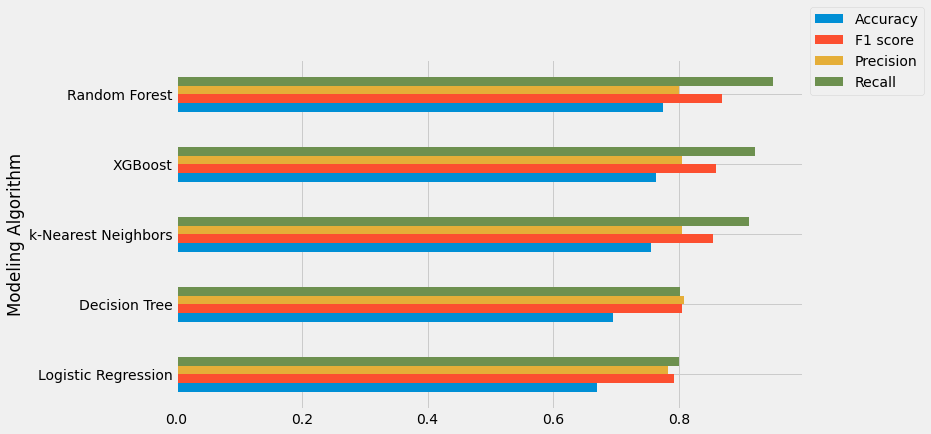

In [11]:
# plot model performances according to 4 traditional metrics
plt.style.use("fivethirtyeight")
ax = score_table.sort_values(by=["F1 score"]).plot(
    kind="barh", x="Modeling Algorithm", figsize=(10, 6), stacked=False
)
ax.legend(bbox_to_anchor=(1, 1.17))
plt.grid(which="minor", axis="x", color="k")
plt.show()
plt.close()

Using default parameters all of our models had apparently a pretty good performance, and as we can see from the previous plot, the best performances were obtained by:
* Random Forest
* XGBoost
* k-Nearest Neighbors

Since we have an imbalanced dataset, accuracy is not the recommended metric to be used. In this case, it's better to use:
* precision (out of those which I classiﬁed as positives correctly predicted, how many are correct?) 
* recall (out of all positives, how many did I found?), 
* or F1 score (balances precision and recall in a single number). Suited for the imbalanced class problem, but less explainable.


|Metrics (T = true, F = false, P = positive, N = negative)                                      |
|:----------------------------------------------------------------------------------------------|
| \begin{align} Accuracy = \frac{TP+TN}{TP+TN+FN+FP} \end{align}                                |
| \begin{align} Recall = \frac{TP}{TP+FN} \end{align}                                           |
| \begin{align} Precision = \frac{TP}{TP+FP} \end{align}                                        |
| \begin{align} F1= \frac{2 \cdot Precision \cdot Recall}{Precision+Recall} \end{align}         |


From our three best performers, the Random Forest will be our choice. From the results we can confirm that accuracy is not the best choice for our problem.

## Random Forest

### Model with default parameters

In [26]:
# create a classifier
rf_model_default = RandomForestClassifier(random_state=42, n_jobs=-1)
# train the model
rf_model_default.fit(X_train, y_train)
# predictions
y_pred = rf_model_default.predict(X_test)

#### Metrics

In [27]:
# model evaluation
model_eval(y_test, y_pred)

F1 score:  0.8684
Precision: 0.8
Recall:    0.9495
Accuracy:  0.7739


#### Confusion matrix

Calculating the confusion matrix helps us to summarize the performance of our model. The convention used by scikit learn is given below.

|  Scikit learn convention   |
|:-----:|
|TN FP|
|FN TP|

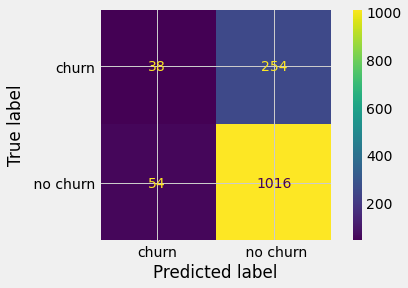

In [28]:
# define class names
class_names = ["churn", " no churn"]

# build the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
# print(f"Confusion matrix:\n{confusion}")

# display the confusion matrix
ConfusionMatrixDisplay(confusion, display_labels=class_names).plot()
plt.show()
plt.close()

The above confusion matrix summarizes the correct and incorrect predictions made by our model. The amount of predicted false positives (top right) and false negatives (top left) increased comparing with the model that keep the features from the BG-NBD model.

#### Save the model

In [17]:
# save the model
dump(rf_model_default, "../models/rf_tree_model_default.joblib")

['../models/model_tree_model_default.joblib']

# Decision Tree

For the sake of comparison with the model with more features let's see how the decision tree performs here.

#### Model with default parameters

In [48]:
# create a classifier
tree_model_reduced = DecisionTreeClassifier(max_depth=5, random_state=42)
# train the model
tree_model_reduced.fit(X_train, y_train)
# predictions
y_pred = tree_model_reduced.predict(X_test)

#### Metrics

In [49]:
# model evaluation
model_eval(y_test, y_pred)

F1 score:  0.8785
Precision: 0.7916
Recall:    0.9869
Accuracy:  0.7856


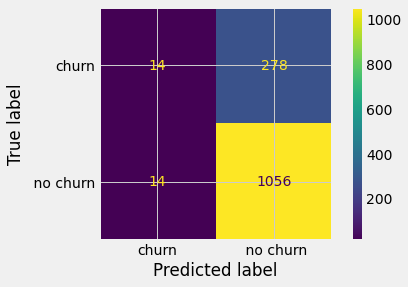

In [50]:
# define class names
class_names = ["churn", " no churn"]

# build the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
# print(f"Confusion matrix:\n{confusion}")

# display the confusion matrix
ConfusionMatrixDisplay(confusion, display_labels=class_names).plot()
plt.show()
plt.close()

Using decision tree with `max_depth=5` decreased the number false negatives, while slightly increasing the number of false positives. It can be further improve with hyperparameter tunning.

In [38]:
feature_names = [
    "deposit_approved_sum",
    "withdrawal_approved_sum",
    "turnover_cash_sum",
    "winning_cash_sum",
    "result_cash_sum",
    "NGR_sum",
    "bonus_cash_sum",
    "session_sum",
    "female",
    "male",
]

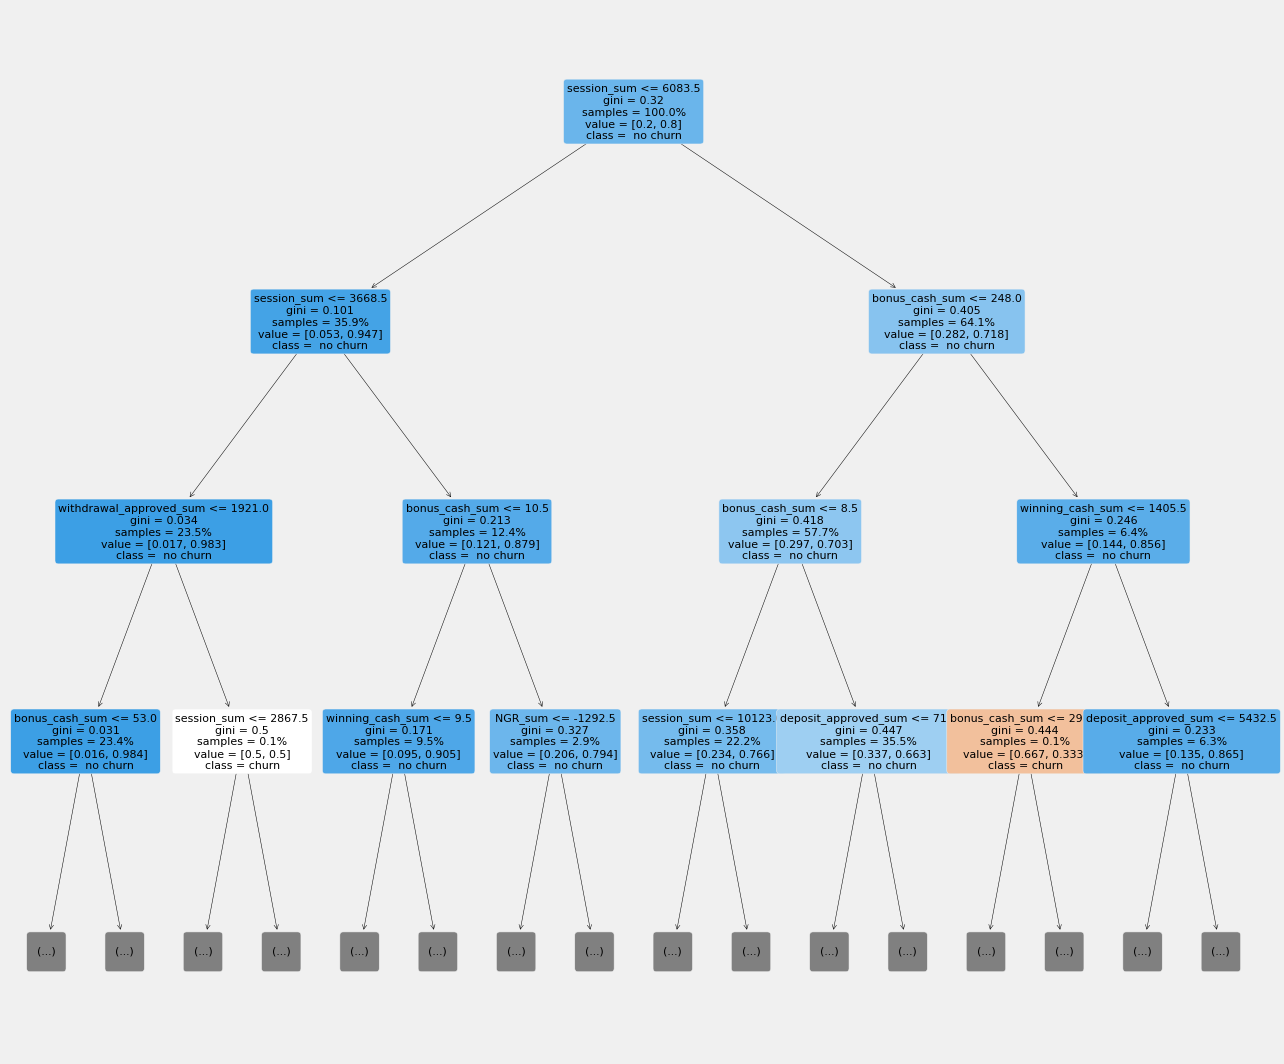

In [42]:
# visualize our tree
fig = plt.figure(figsize=(20, 18))
_ = tree.plot_tree(
    tree_model_reduced,
    max_depth=3,
    feature_names=feature_names,
    class_names=class_names,
    proportion=True,
    filled=True,
    rounded=True,
    fontsize=11,
)

For the sake of clarity, the tree plot above is shown with `max_depth=3`, but the model was build `max_depth=5`.

Now we have a completely different model, that is more suitable to be used with the original dataset.

#### Learning curve

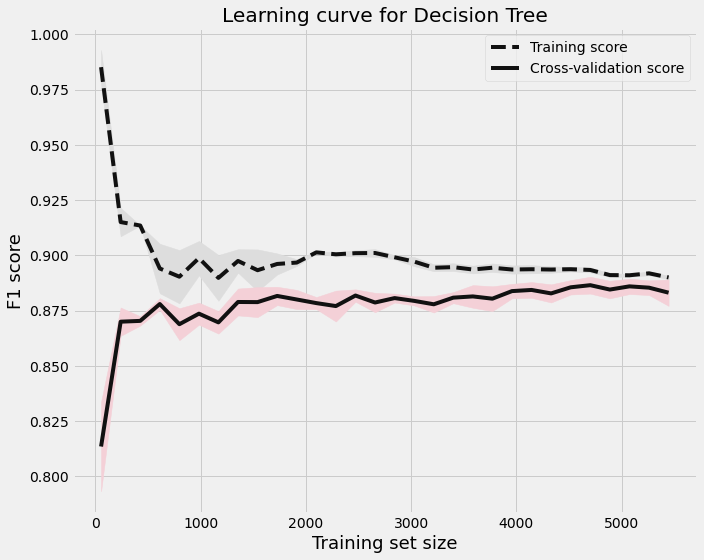

In [51]:
plt.figure(figsize=(10, 8))
plot_learning_curve(X, y, 5, plt)